In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import admix
import admix_prs
import statsmodels.api as sm

np.random.seed(1)

In [2]:
COVAR_PATH = "DATA/covariates.txt"
df_covar = pd.read_csv(COVAR_PATH, sep="\t", index_col=0)

PHENO_PATH = "DATA/all-pheno.csv"
df_pheno = pd.read_csv(PHENO_PATH, index_col=0)

idx = list(set(df_covar.index) & set(df_pheno.index))
df_info = df_pheno.loc[idx].copy()
df_covar = df_covar.loc[idx]

for col in ["deprivation_index", "group"]:
    df_info[col] = df_covar[col]

df_info.index = df_info.index.astype(str) + "_" + df_info.index.astype(str)

# TODO: maybe it is necessary to perform quantile normalization
# df_trait_pheno["REAL"] = admix.data.quantile_normalize(df_trait_pheno["REAL"])

# load trait prediction
for trait in ["height", "ldl_direct", "bmi"]:
    df_prs = pd.read_csv(f"DATA/{trait}.tsv.gz", sep="\t", index_col=0)
    df_info[trait] = admix.data.quantile_normalize(df_info[trait])
    df_info[f"{trait}_PRED_MEAN"] = df_prs["MEAN"].reindex(df_info.index)
    df_info[f"{trait}_PRED_STD"] = df_prs["SD"].reindex(df_info.index)

In [3]:
with open("DATA/uk_train.list") as f:
    train_list = ["_".join(l.strip().split("\t")) for l in f.readlines()]
    train_list = list(set(train_list) & set(df_info.index))

In [4]:
# add covariate effects

covar_cols = [f"PC{i}" for i in range(1, 21)] + ["AGE"] + ["SEX"]
model = sm.OLS(
    df_info[trait], sm.add_constant(df_info[covar_cols]), missing="drop"
).fit()
# df_info[f"{trait}_PRED_MEAN"] += model.predict(sm.add_constant(df_info[covar_cols]))
df_info[trait] -= model.predict(sm.add_constant(df_info[covar_cols]))

In [5]:
df_info = df_info[df_info["PC1"] > 10].dropna().copy()

# make levels
for col in ["PC1", "PC2", "AGE"]:
    df_info[f"{col}_Q"] = pd.qcut(df_info[col], q=5)

In [6]:
het_stats, het_model = admix_prs.test_het_breuschpagan(
    df=df_info.dropna(),
    y_col=trait,
    pred_col=f"{trait}_PRED_MEAN",
    test_col="AGE",
)
display(het_stats)

# we see a positive variance associated with PC1
print(het_model.summary())

Lagrange multiplier statistic    3.011151e+01
p-value                          4.079020e-08
f-value                          3.016178e+01
f p-value                        4.032095e-08
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     30.16
Date:                Thu, 17 Feb 2022   Prob (F-statistic):           4.03e-08
Time:                        15:38:05   Log-Likelihood:                -28355.
No. Observations:               16870   AIC:                         5.671e+04
Df Residuals:                   16868   BIC:                         5.673e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2426      0.065     19.028      0.0

## Raw results

In [7]:
from IPython.display import display, Markdown, Latex

In [8]:
df_tmp = df_info.dropna().copy()
df_tmp[f"{trait}_PRED_MEAN"] += (
    df_tmp[f"{trait}"].mean() - df_tmp[f"{trait}_PRED_MEAN"].mean()
)

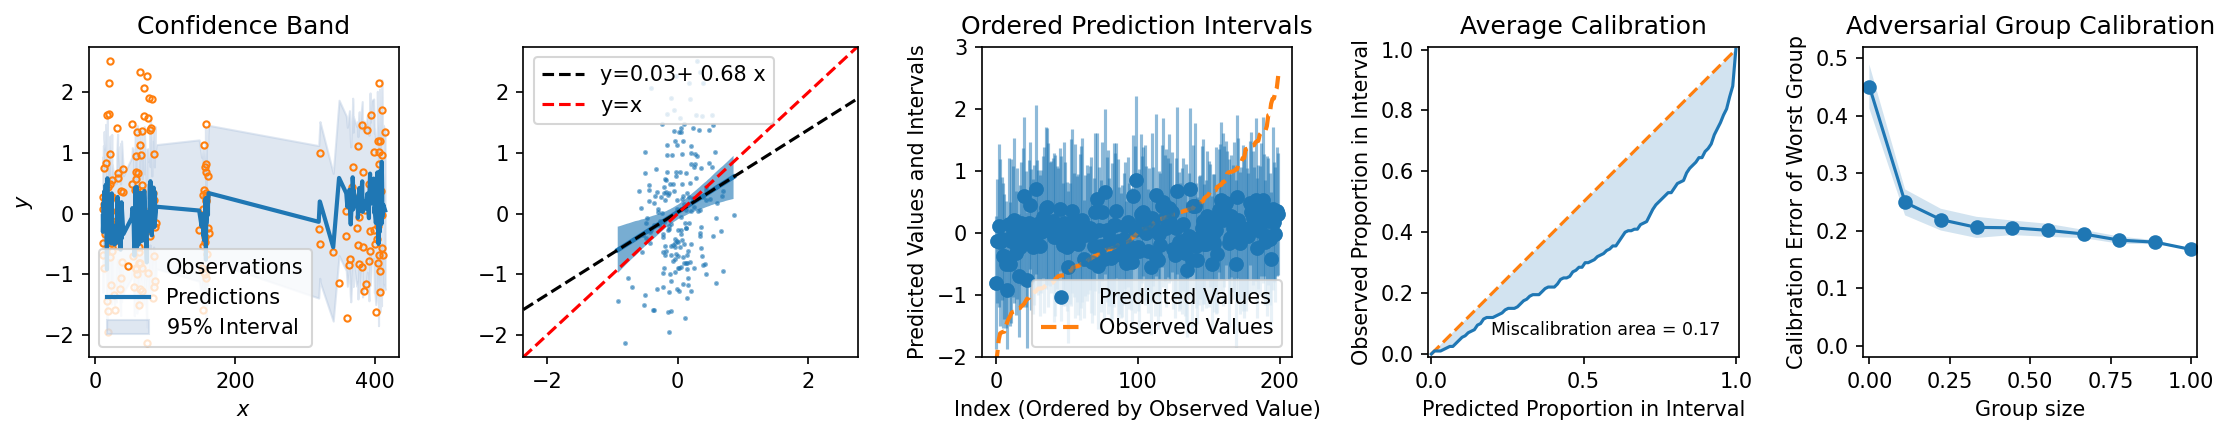

In [9]:
df_tmp = df_tmp.sample(n=200, random_state=42)
admix_prs.uct_plot(
    pred_mean=df_tmp[f"{trait}_PRED_MEAN"].values,
    pred_std=df_tmp[f"{trait}_PRED_STD"].values,
    y=df_tmp[trait].values,
    x=df_tmp["PC1"].values,
)

In [10]:
for col in ["PC1_Q", "PC2_Q", "SEX", "AGE_Q"]:
    display(Markdown(f"### {col}"))

    display(
        admix_prs.evaluate(
            df_info,
            y_col=trait,
            pred_col=f"{trait}_PRED_MEAN",
            predstd_col=f"{trait}_PRED_STD",
            group_col=col,
        )
    )

### PC1_Q

,r2,coverage,length,y_std,pred_std
PC1_Q,,,,,
"(9.999, 23.853]",0.178537,0.633669,0.818308,1.008690,0.342356
"(23.853, 64.101]",0.092580,0.653231,0.836377,0.948376,0.305576
"(64.101, 152.531]",0.084785,0.642857,0.856699,0.973178,0.291793
"(152.531, 380.798]",0.028589,0.688797,1.003160,0.970714,0.311252
"(380.798, 419.396]",0.020470,0.696206,1.089973,0.981106,0.221523


### PC2_Q

,r2,coverage,length,y_std,pred_std
PC2_Q,,,,,
"(-282.318, -104.223]",0.054290,0.684055,0.892327,0.921491,0.287704
"(-104.223, -57.256]",0.082275,0.637226,0.846069,0.980233,0.299693
"(-57.256, -8.981]",0.161874,0.646414,0.822764,0.971015,0.330250
"(-8.981, 72.211]",0.093686,0.649081,0.954443,1.033871,0.293292
"(72.211, 86.112]",0.018893,0.697985,1.088913,0.972347,0.224063


### SEX

,r2,coverage,length,y_std,pred_std
SEX,,,,,
0,0.103391,0.639320,0.927912,1.044266,0.310009
1,0.035982,0.689254,0.913103,0.877020,0.307274


### AGE_Q

,r2,coverage,length,y_std,pred_std
AGE_Q,,,,,
"(37.999, 45.0]",0.052902,0.658124,0.935247,0.990502,0.299154
"(45.0, 50.0]",0.062389,0.664166,0.935783,0.993225,0.304542
"(50.0, 56.0]",0.076126,0.655568,0.925353,1.006768,0.310435
"(56.0, 62.0]",0.075717,0.676471,0.899296,0.947781,0.316025
"(62.0, 72.0]",0.085925,0.662126,0.904478,0.929448,0.312473


# Perform calibration

In [11]:
np.random.seed(1)

calibrate_idx = np.random.choice(
    df_info.index, size=int(len(df_info) * 0.1), replace=False
).tolist()
test_idx = list(set(df_info.index) - set(calibrate_idx))

# perform calibration
df_calibrated = admix_prs.calibrate_pred(
    df_info,
    y_col=trait,
    pred_col=f"{trait}_PRED_MEAN",
    predstd_col=f"{trait}_PRED_STD",
    calibrate_idx=calibrate_idx,
    ci_method="scale",
    ci_adjust_cols=["PC1", "PC2"],
    ci=0.9,
)
covar_cols = [trait, "PC1", "PC1_Q", "PC2_Q", "SEX", "AGE_Q"]
df_calibrated[covar_cols] = df_info[covar_cols].reindex(df_calibrated.index)

for col in ["PC1_Q"]:
    display(Markdown(f"### {col}"))

    display(
        admix_prs.evaluate(
            df_calibrated.loc[
                test_idx,
            ],
            y_col=trait,
            pred_col=f"{trait}_PRED_MEAN",
            predstd_col=f"{trait}_PRED_STD",
            group_col=col,
            ci=0.9,
        )
    )

2022-02-17 15:38.08 [info     ] Regress pred_col=bmi_PRED_MEAN against mean_adjust_cols=[] fitted with `calibrate_index` individuals
2022-02-17 15:38.08 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     118.4
Date:                Thu, 17 Feb 2022   Prob (F-statistic):           1.08e-26
Time:                        15:38:08   Log-Likelihood:                -2278.1
No. Observations:                1687   AIC:                             4560.
Df Residuals:                    1685   BIC:                             4571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coe

### PC1_Q

,r2,coverage,length,y_std,pred_std
PC1_Q,,,,,
"(9.999, 23.853]",0.183897,0.909091,1.559952,1.003942,0.272375
"(23.853, 64.101]",0.096425,0.909812,1.539253,0.959343,0.243580
"(64.101, 152.531]",0.086508,0.901161,1.522637,0.965533,0.231894
"(152.531, 380.798]",0.024646,0.881523,1.519351,0.977092,0.246026
"(380.798, 419.396]",0.019896,0.880105,1.527934,0.981308,0.177897


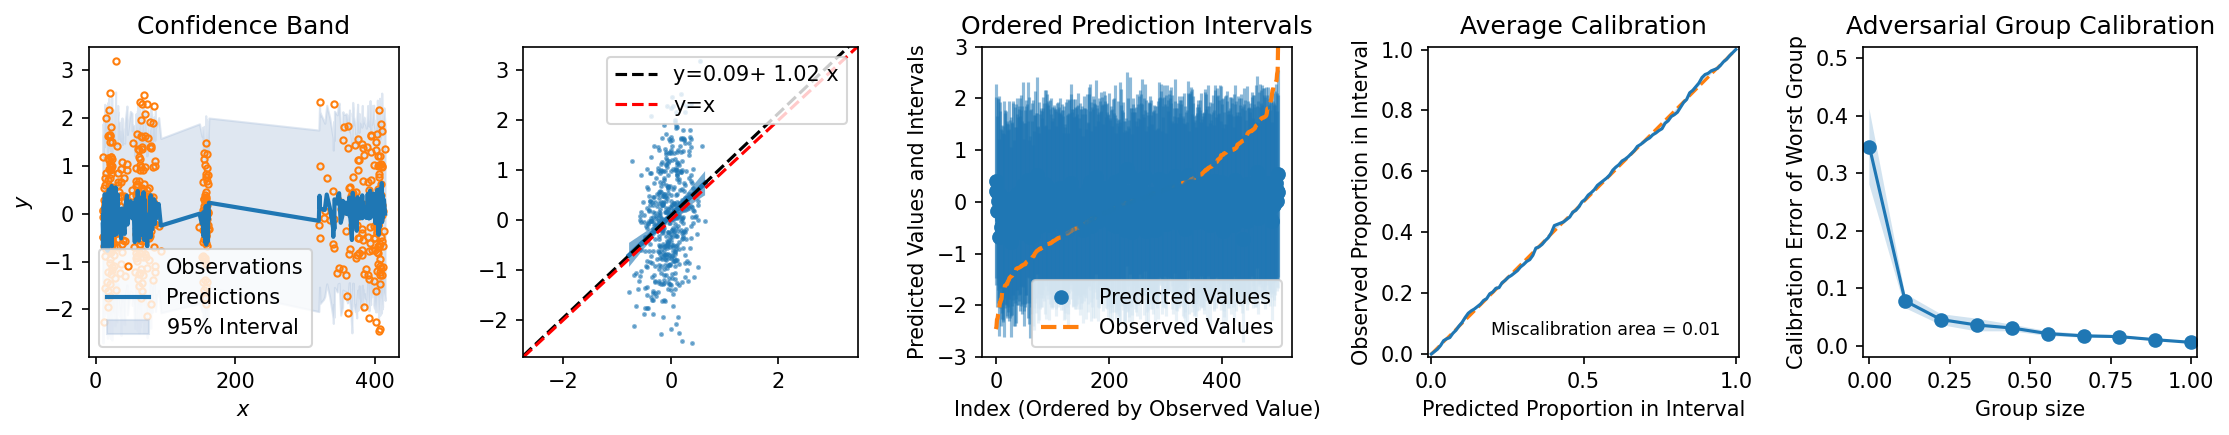

In [12]:
df_tmp = df_calibrated.sample(n=500, random_state=42)
admix_prs.uct_plot(
    pred_mean=df_tmp[f"{trait}_PRED_MEAN"].values,
    pred_std=df_tmp[f"{trait}_PRED_STD"].values,
    y=df_tmp[trait].values,
    x=df_tmp["PC1"].values,
)

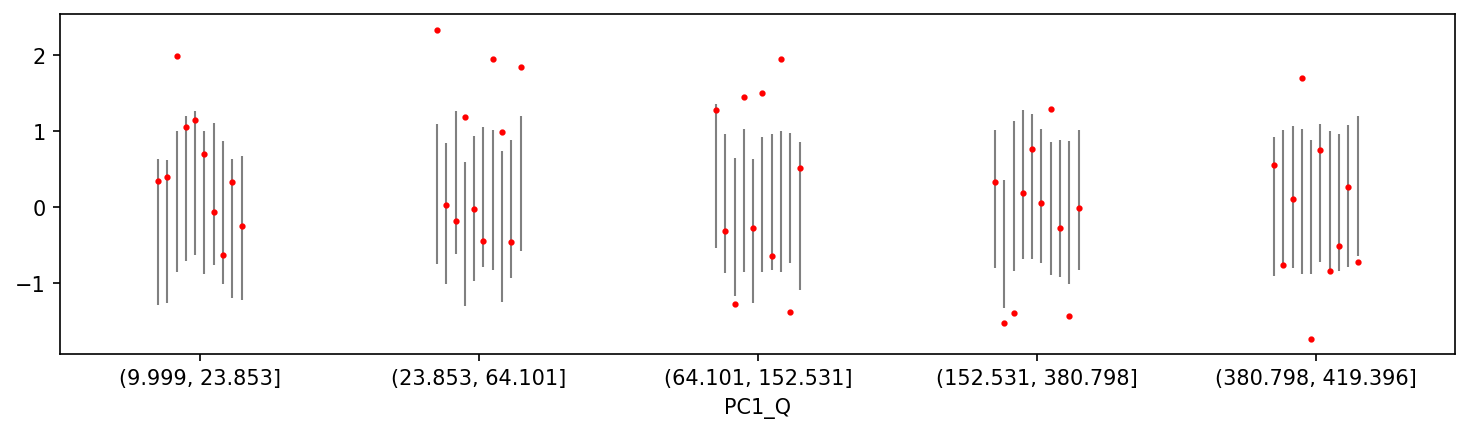

In [13]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=150)
admix_prs.plot_calibration(
    df=df_calibrated,
    y_col=trait,
    pred_col=f"{trait}_PRED_MEAN",
    predstd_col=f"{trait}_PRED_STD",
    group_col="PC1_Q",
    ax=ax,
)

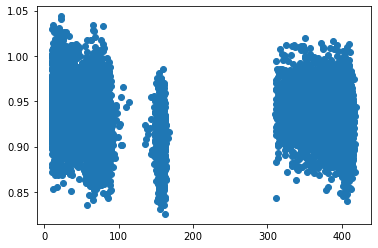

In [14]:
plt.scatter(df_calibrated["PC1"], df_calibrated[f"{trait}_PRED_STD"])